In [39]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress a specific warning type
warnings.filterwarnings("ignore", category=DeprecationWarning)

def is_exhausted(row, threshold_pace="2:15", threshold_spm=35):
    # Convert the pace to seconds for comparison
    pace_seconds = int(row['split_avg_pace'].split(":")[0]) * 60 + float(row['split_avg_pace'].split(":")[1])
    threshold_pace_seconds = int(threshold_pace.split(":")[0]) * 60 + float(threshold_pace.split(":")[1])
    
    return pace_seconds > threshold_pace_seconds or row['split_stroke_rate'] > threshold_spm

In [40]:
initial_threshold_pace = "2:15"  
initial_threshold_spm = 35 

In [41]:
# Load the data
df = pd.read_json("Test/ergometer_500m.json")

# Define target variable (e.g., speed) and features (time)
X = df['split_calories'].values.reshape(-1, 1)  # Time as the independent variable

# Calcul de la vitesse en km/h (distance en km / temps en heures)
df['split_time_hours'] = df['split_time'] / 3600  # Conversion du temps en heures
df['speed_kmh'] = (0.5 / df['split_time_hours'])  # La distance est de 0.5 km (500m)
df['speed_category'] = pd.cut(df['speed_kmh'], bins=[0, 13.5, 15, 20], labels=[0, 1, 2])

y = df['speed_category']

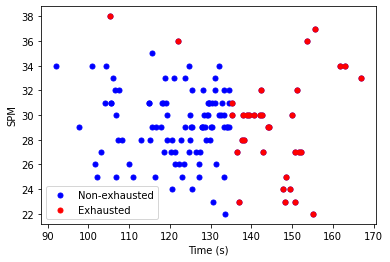

In [42]:
df['exhausted'] = df.apply(is_exhausted, axis=1)
exhausted_rows = df[df['exhausted'] == True]

# Plot the results
plt.scatter(df['split_time'], df['split_stroke_rate'], color='blue', label='Non-exhausted',s=25)
plt.scatter(exhausted_rows['split_time'], exhausted_rows['split_stroke_rate'], color='red', label='Exhausted',s=25)
plt.xlabel('Time (s)')
plt.ylabel('SPM')
plt.legend()
plt.show()

In [43]:
df['true_exhaustion'] = df['split_avg_pace'].apply(lambda x: 1 if x > "2:15" else 0)  # 1 indicates exhausted, 0 indicates not exhausted
true_exhaustion_labels = df['exhausted']

In [44]:
# finetune
thresholds_pace = ["2:10", "2:15", "2:20"]
thresholds_spm = [30, 35, 40]

for pace in thresholds_pace:
    for spm in thresholds_spm:
        df['exhausted'] = df.apply(is_exhausted, threshold_pace=pace, threshold_spm=spm, axis=1)
        accuracy = accuracy_score(true_exhaustion_labels, df['exhausted'])
        print(f'Pace Threshold: {pace}, SPM Threshold: {spm} -> Accuracy: {accuracy}')

Pace Threshold: 2:10, SPM Threshold: 30 -> Accuracy: 0.640625
Pace Threshold: 2:10, SPM Threshold: 35 -> Accuracy: 0.828125
Pace Threshold: 2:10, SPM Threshold: 40 -> Accuracy: 0.8125
Pace Threshold: 2:15, SPM Threshold: 30 -> Accuracy: 0.7421875
Pace Threshold: 2:15, SPM Threshold: 35 -> Accuracy: 1.0
Pace Threshold: 2:15, SPM Threshold: 40 -> Accuracy: 0.984375
Pace Threshold: 2:20, SPM Threshold: 30 -> Accuracy: 0.6796875
Pace Threshold: 2:20, SPM Threshold: 35 -> Accuracy: 0.9296875
Pace Threshold: 2:20, SPM Threshold: 40 -> Accuracy: 0.9140625


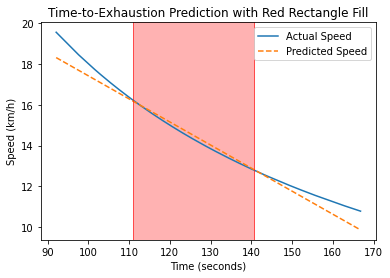

In [46]:
X = df['split_time'].values.reshape(-1, 1) 
y = df['speed_kmh'].values 

model = LinearRegression()
model.fit(X, y)

# Predict speed over time
predicted_speed = model.predict(X)

# Convert X to a 1D array
Xp = X.flatten()  # Flatten the 2D array into 1D
arg = np.argsort(Xp)  # Sort X values
Xp_sorted = Xp[arg]
y_sorted = y[arg]
predicted_speed_sorted = predicted_speed[arg]

plt.plot(Xp_sorted, y_sorted, label='Actual Speed')
plt.plot(Xp_sorted, predicted_speed_sorted, label='Predicted Speed', linestyle='--')

intersections = np.where(np.diff(np.sign(y_sorted - predicted_speed_sorted)))[0]

if len(intersections) > 1:
    x_fill_start = Xp_sorted[intersections[0]]
    x_fill_end = Xp_sorted[intersections[1]]
    
    plt.axvline(x_fill_start, color='red', linestyle='-', linewidth=0.5)
    plt.axvline(x_fill_end, color='red', linestyle='-', linewidth=0.5)

    plt.axvspan(x_fill_start, x_fill_end, color='red', alpha=0.3)

plt.title('Time-to-Exhaustion Prediction with Red Rectangle Fill')
plt.xlabel('Time (seconds)')
plt.ylabel('Speed (km/h)')
plt.legend()
plt.show()